# Proyek Analisis Sentimen pada Review Sebuah Restoran

Tujuan dari proyek ini adalah untuk membuat sebuah model yang dapat memprediksi apakah review sebuah restoran merupakan review positif atau negatif. Proyek ini menggunakan [dataset yield](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set), dataset tersebut yang berisi kumpulan review terhap sebuah restoran.

In [7]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense#, LSTM, Bidirectional
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import json

## Mempersiapkan Dataset

In [8]:
df = pd.read_csv('yelp_labelled.txt', names=['sentence', 'label'], sep='\t')
df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Berdasarkan keterangan di atas diketahui bahwa dataset yang digunakan terdiri dari 1000 data dan tidak terdapat *missing value*.

## Preprocessing Data

### Mengubah seluruh text kedalam bentuk lowercase

In [12]:
df['sentence'] = df['sentence'].str.lower()

df.head()

,sentence,label
0,wow... loved this place.,1
1,crust is not good.,0
2,not tasty and the texture was just nasty.,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


### Menghilangkan [stopwords](https://en.wikipedia.org/wiki/Stop_word)

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/maderahano/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stop_word = set(stopwords.words('english'))

df['sentence'] = df['sentence'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop_word)]))

df.head()

,sentence,label
0,wow... loved place.,1
1,crust good.,0
2,tasty texture nasty.,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices.,1


### Melakukan split dataset

In [15]:
sentence = df['sentence'].values
label = df['label'].values

In [16]:
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2, shuffle=False)

print('Training dataset:\n', sentence_train.shape, label_train.shape)
print('\nTest dataset:\n', sentence_test.shape, label_test.shape)

Training dataset:
 (800,) (800,)

Test dataset:
 (200,) (200,)


### Membuat tokenisasi

In [17]:
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ' # Untuk menghilangkan symbols

tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>", filters=filt)

tokenizer.fit_on_texts(sentence_train)

In [18]:
word_index = tokenizer.word_index
print(len(word_index))

1732


In [19]:
# Menyimpan word_index kedalam sebuah file json

with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

### Membuat sequences dan melakukan padding

In [20]:
train_sekuens = tokenizer.texts_to_sequences(sentence_train)
test_sekuens = tokenizer.texts_to_sequences(sentence_test)


train_padded = pad_sequences(train_sekuens, 
                             maxlen=20,
                             padding='post',
                             truncating='post')
test_padded = pad_sequences(test_sekuens,
                            maxlen=20,
                            padding='post',
                            truncating='post')

In [21]:
train_padded.shape

(800, 20)

In [22]:
test_padded.shape

(200, 20)

## Membuat Model

In [23]:
model = tf.keras.Sequential([
    Embedding(2000, 20, input_length=20),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            40000     
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 43457 (169.75 KB)
Trainable params: 43457 (169.75 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

2024-01-16 02:22:54.630863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 02:22:54.632110: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Melatih Model

In [25]:
num_epochs = 30
history = model.fit(train_padded, label_train, 
                    epochs=num_epochs, 
                    validation_data=(test_padded, label_test),
                    verbose=1)

Epoch 1/30
25/25 [==============================] - 1s 8ms/step - loss: 0.6903 - accuracy: 0.5425 - val_loss: 0.7329 - val_accuracy: 0.2400
Epoch 2/30
25/25 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5650 - val_loss: 0.7585 - val_accuracy: 0.2400
Epoch 3/30
25/25 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.5650 - val_loss: 0.7721 - val_accuracy: 0.2400
Epoch 4/30
25/25 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.5650 - val_loss: 0.7743 - val_accuracy: 0.2400
Epoch 5/30
25/25 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6237 - val_loss: 0.7447 - val_accuracy: 0.3050
Epoch 6/30
25/25 [==============================] - 0s 3ms/step - loss: 0.5269 - accuracy: 0.7850 - val_loss: 0.6855 - val_accuracy: 0.5250
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 0.3684 - accuracy: 0.9050 - val_loss: 0.5894 - val_accuracy: 0.7050
Epoch 8/30
25/25 [==

## Evaluasi Model

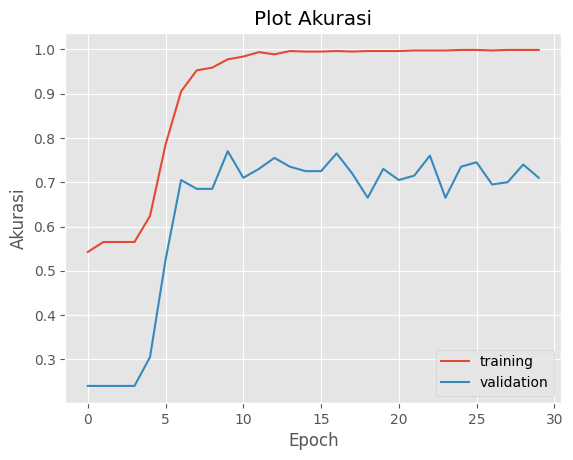

In [26]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="validation")
plt.title("Plot Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.savefig('images/plot_acc.png')
plt.show()

Berdasarkan plot tersebut dapat dilihat bahwa model yang digunakan masih sangat overfit 

## Save Model

In [27]:
model.save("model.h5")

/home/maderahano/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Convert Model

In [28]:
# Install tensorflowjs

!pip install tensorflowjs

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 KB 472.6 kB/s eta 0:00:001m353.1 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 9.9 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 KB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 4.9 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.0/200.0 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 10.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━

In [31]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-01-16 02:24:33.187998: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 02:24:33.228416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 02:24:33.228466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 02:24:33.229546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 02:24:33.236614: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 02:24:33.236789: I tensorflow/core/platform/cpu_feature_guard.cc:1